In [1]:
# libs

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyod.models.knn import KNN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
# Dataset

data = pd.read_csv('houses_to_rent.csv')
data.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [3]:
print(f"O DataFrame possui {data.shape[0]} registros e {data.shape[1]} colunas.")

O DataFrame possui 10692 registros e 13 colunas.


In [4]:
# visualizando as colunas

data.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

In [5]:
# renomeando as colunas

data.rename(columns={'parking spaces':'parking_spaces','hoa (R$)':'hoa', 'rent amount (R$)':'rent',
       'property tax (R$)': 'property_tax', 'fire insurance (R$)':'fire_insurance', 'total (R$)':'total'}, inplace=True)

In [6]:
data.dtypes

city              object
area               int64
rooms              int64
bathroom           int64
parking_spaces     int64
floor             object
animal            object
furniture         object
hoa                int64
rent               int64
property_tax       int64
fire_insurance     int64
total              int64
dtype: object

In [7]:
# transformando algumas colunas em string

#selecionados = ['area', 'rooms', 'bathroom', 'parking_spaces']

#for coluna in selecionados:
#    data[coluna] = data[coluna].astype(str)

In [8]:
#data.dtypes

In [9]:
# visualizando dados nulos

data.isnull().sum()

print("Não há ocorrencia de dados nulos")

Não há ocorrencia de dados nulos


In [10]:
# verificando dados duplicados

data.duplicated().sum()

358

In [11]:
# removendo dados duplicados

data.drop_duplicates(inplace=True)

In [12]:
# verificando a remoção de duplicados

data.duplicated().sum()

0

In [13]:
# após a remoção dos dados duplicados

data.shape

(10334, 13)

## Identificando outliers

In [14]:
# removendo a variavel target
df = data.iloc[:,8:14]
df.head()

,hoa,rent,property_tax,fire_insurance,total
0,2065,3300,211,42,5618
1,1200,4960,1750,63,7973
2,1000,2800,0,41,3841
3,270,1112,22,17,1421
4,0,800,25,11,836


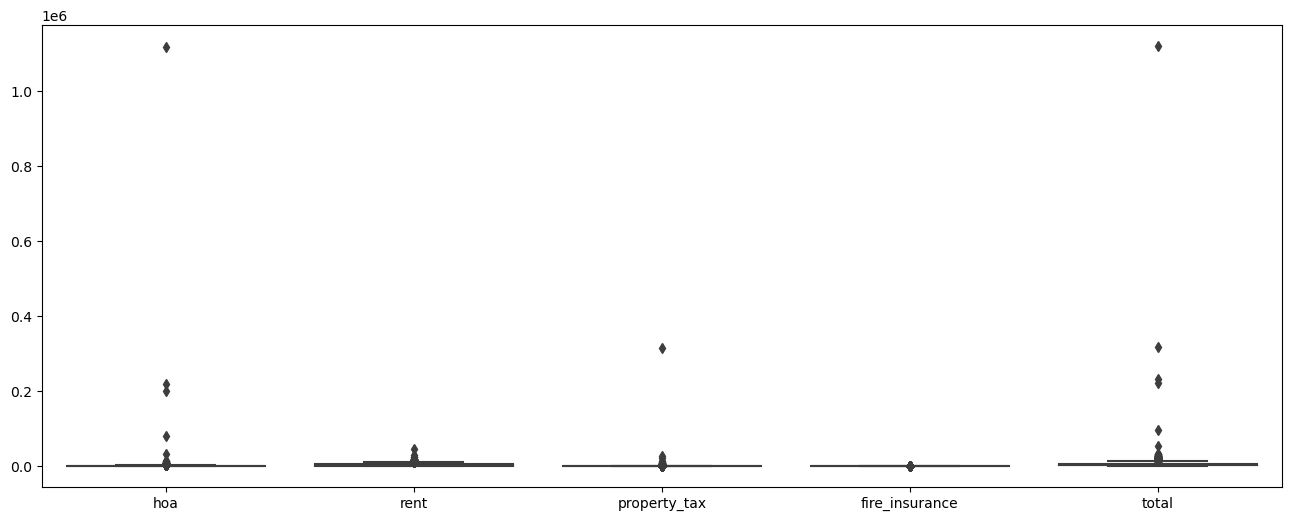

In [15]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(data = df)

hoa : int64
rent : int64
property_tax : int64
fire_insurance : int64
total : int64


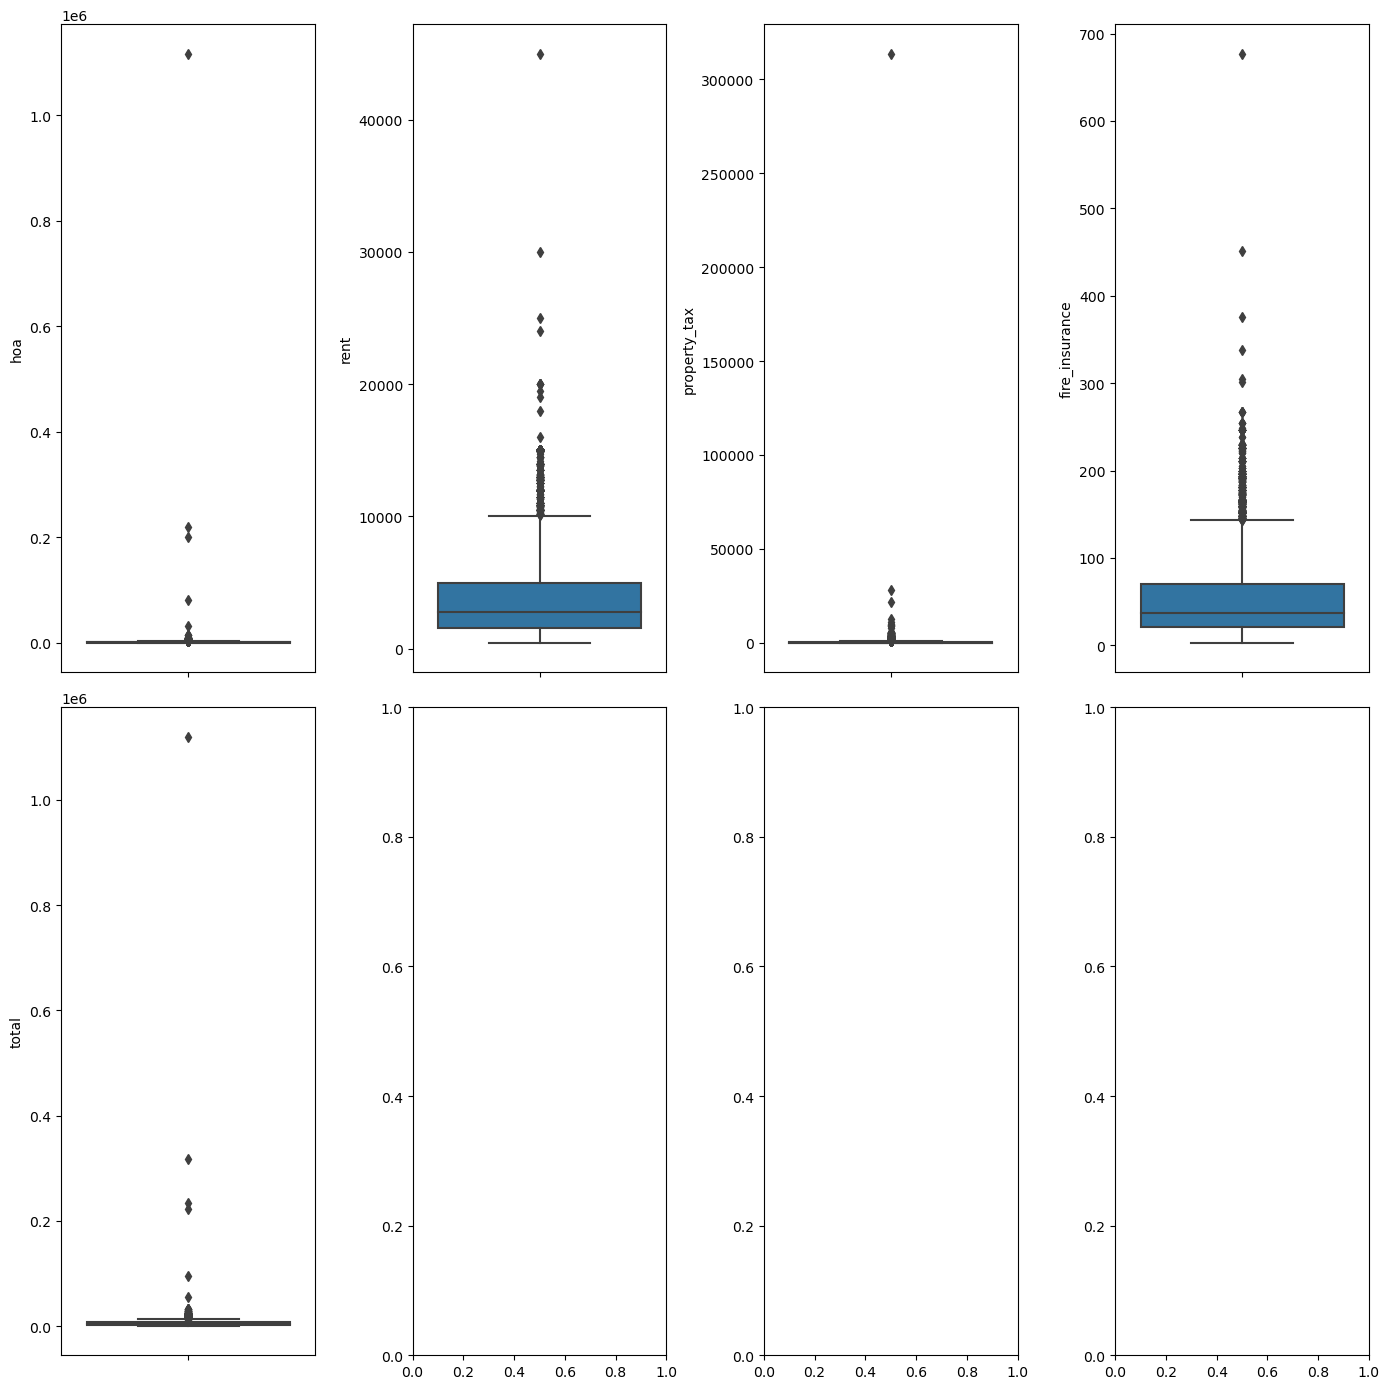

In [16]:
numeric_variables = []
for i in df.columns[0:13].tolist():
    if df.dtypes[i] == 'int64' or df.dtypes[i] == 'float64':
        print(i, ':', df.dtypes[i])
        numeric_variables.append(i)
plt.rcParams['figure.figsize'] = [14.00, 14.00]
plt.rcParams['figure.autolayout'] = True

plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 20

f, axes = plt.subplots(2,4) # 2 linhas e 4 colunas

line = 0
column = 0

for i in numeric_variables:
    sns.boxplot(data = df, y=i, ax=axes[line][column])
    column +=1
    if column == 4:
        line += 1
        column = 0
plt.show()

In [17]:
# instanciando o objeto KNN
detector = KNN()

# treinando um detector de Outliers
detector.fit(df)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [18]:
# labels_ retorno um array com 0 e 1
# 0 nao é outlier e 1 é outlier

predictions = detector.labels_
predictions

array([0, 1, 0, ..., 0, 1, 0])

In [19]:
# contagem para identificar oss outliers

np.unique(predictions, return_counts=True)

(array([0, 1]), array([9300, 1034], dtype=int64))

In [20]:
# observando o calculo da distancia realizado para identificar outlier

trust_prediction = detector.decision_scores_
trust_prediction

array([ 234.95105873, 1005.547612  ,  141.5344481 , ...,  187.48333259,
        502.86081573,   95.53009997])

In [21]:
# criando lista somente com os outliers
outliers = []

for i in range(len(predictions)):
    if predictions[i] == 1:
        outliers.append(i)

In [22]:
list_outliers = data.iloc[outliers,:]
list_outliers.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent,property_tax,fire_insurance,total
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
7,São Paulo,213,4,4,4,4,acept,not furnished,2254,3223,1735,41,7253
8,São Paulo,152,2,2,1,3,acept,furnished,1000,15000,250,191,16440
19,São Paulo,600,4,5,6,-,acept,not furnished,0,12000,9500,181,21680
40,São Paulo,300,4,6,4,20,acept,not furnished,3700,12000,1584,153,17440


In [23]:
# 5 alugueis com valor mais elevados
top_five = list_outliers['total'].nlargest(5)
index_topFive = top_five.index.tolist()
#index_topFive

# identificando as colunas dos alugueis com valores muito elevado
top = pd.DataFrame(data.iloc[index_topFive]).sort_values(by='total', ascending=False)
top

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent,property_tax,fire_insurance,total
6369,São Paulo,280,4,4,4,1,acept,furnished,3600,12000,1667,172,17440
6799,São Paulo,183,4,3,4,3,acept,not furnished,2380,5950,192,76,8598
2900,São Paulo,180,3,3,1,-,acept,furnished,1785,6000,294,77,8156
2970,Campinas,100,2,2,1,11,acept,not furnished,0,2000,0,26,2026
256,São Paulo,40,1,1,0,-,not acept,not furnished,0,1300,0,17,1317


In [24]:
list_outliers.shape

(1034, 13)

In [25]:
data.shape

(10334, 13)

In [26]:
# concatenando 'data' e 'lista_outliers' 
#criei uma duplicação dos dados
df = pd.concat([data,list_outliers])
df.shape

(11368, 13)

In [27]:
# removendo outliers do dataframe com drop_duplicates
# using method keep=False
df = df.drop_duplicates(keep=False)
df.shape

(9300, 13)

### Variável "City"

In [28]:
# cidades

df["city"].value_counts().sort_values(ascending=False)

São Paulo         4879
Rio de Janeiro    1348
Belo Horizonte    1153
Porto Alegre      1126
Campinas           794
Name: city, dtype: int64

In [29]:
# percentual de casa por cidade

city_counts = df['city'].value_counts()
city_percentagens = city_counts / len(df) * 100
city_percentagens.sort_values(ascending=False).round(1).map("{:.1f}%".format)

São Paulo         52.5%
Rio de Janeiro    14.5%
Belo Horizonte    12.4%
Porto Alegre      12.1%
Campinas           8.5%
Name: city, dtype: object

Text(0.5, 1.0, 'Count City')

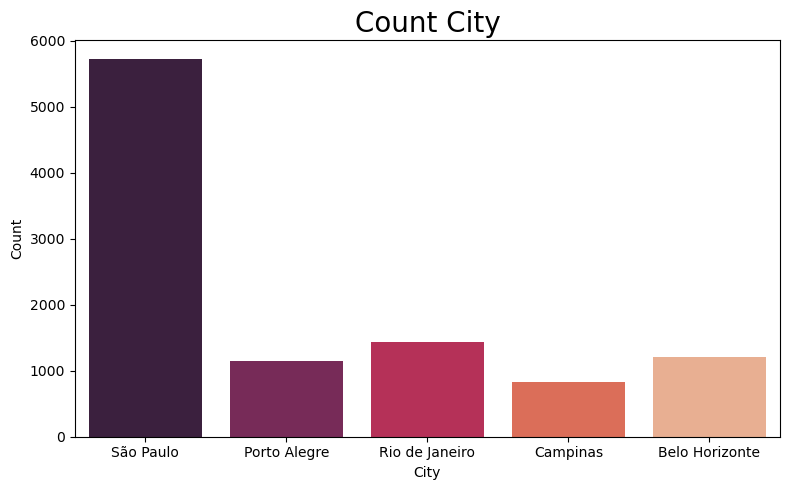

In [30]:
# numero de casas para alugar por cidade

plt.figure(figsize=(8,5))
sns.countplot(data=data, x=data['city'], palette="rocket")
plt.ylabel('Count')
plt.xlabel('City')
plt.title('Count City')

In [31]:
# preço médio de aluguel por cidade 

df.groupby('city')['rent'].median().sort_values(ascending=False)

city
São Paulo         3000.0
Rio de Janeiro    2300.0
Belo Horizonte    2250.0
Porto Alegre      1600.0
Campinas          1500.0
Name: rent, dtype: float64

In [32]:
# valor de aluguel que mais se repete por cidade

df.groupby('city')['rent'].apply(lambda x: x.mode().iloc[0]).sort_values(ascending=False)

city
Porto Alegre      2500
Rio de Janeiro    2500
São Paulo         2500
Campinas          1200
Belo Horizonte    1100
Name: rent, dtype: int64

Text(0.5, 1.0, 'City x Rent')

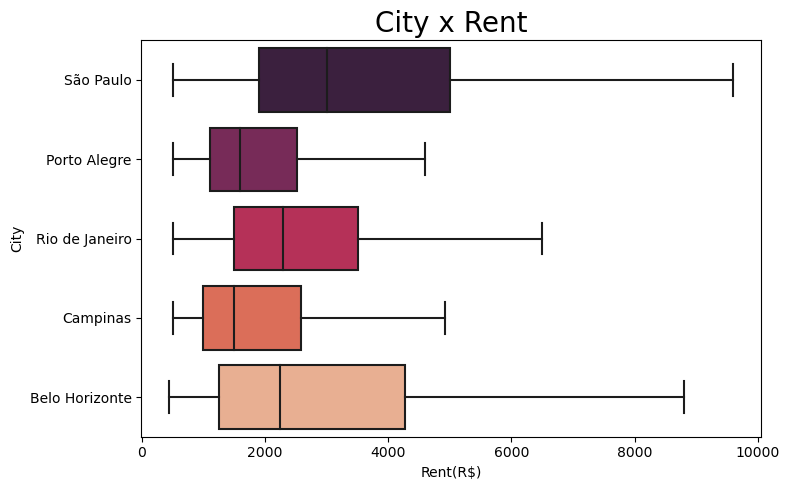

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df['city'], x=df['rent'],showfliers=False, palette="rocket")
plt.ylabel('City')
plt.xlabel('Rent(R$)')
plt.title('City x Rent')

### Variável "animal"

In [34]:
# verificando a variavel animal

df['animal'].value_counts().sort_values(ascending=False)

acept        7219
not acept    2081
Name: animal, dtype: int64

In [35]:
# percentual de aceitação de animais

animal_counts = df['animal'].value_counts()
animal_percentagens = animal_counts / len(df) * 100
animal_percentagens.sort_values(ascending=False).round(1).map("{:.1f}%".format)

acept        77.6%
not acept    22.4%
Name: animal, dtype: object

In [36]:
# media de preço onde possui e nao possui animais

df.groupby('animal')['rent'].median().sort_values()

animal
not acept    2230.0
acept        2500.0
Name: rent, dtype: float64

In [37]:
df.groupby('animal')['city'].value_counts()

animal     city          
acept      São Paulo         3678
           Rio de Janeiro    1079
           Porto Alegre       966
           Belo Horizonte     857
           Campinas           639
not acept  São Paulo         1201
           Belo Horizonte     296
           Rio de Janeiro     269
           Porto Alegre       160
           Campinas           155
Name: city, dtype: int64

Text(0.5, 1.0, 'accept animal or not x City')

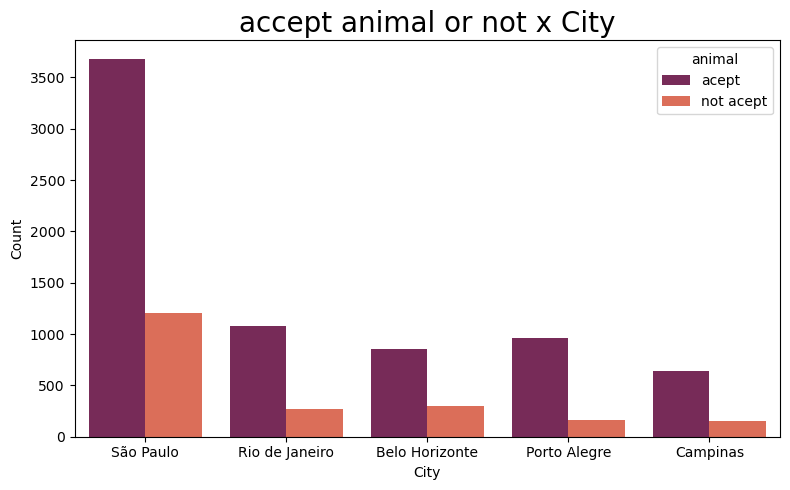

In [38]:
# visualizando 

plt.figure(figsize=(8,5))
sns.countplot(data=df, x=df['city'], hue=df['animal'], palette='rocket', order=df['city'].value_counts().index)
plt.ylabel('Count')
plt.xlabel('City')
plt.title('accept animal or not x City')

### Variável "furniture"

In [39]:
# verificando a variável "furniture"

df['furniture'].value_counts(ascending=False)

not furnished    7121
furnished        2179
Name: furniture, dtype: int64

In [40]:
# percentual de imóveis imobiliados ou não

furniture_counts = df['furniture'].value_counts()
furniture_percentagens = furniture_counts / len(df) * 100
furniture_percentagens.sort_values(ascending=False).round(1).map("{:.1f}%".format)

not furnished    76.6%
furnished        23.4%
Name: furniture, dtype: object

Text(0.5, 1.0, 'Furniture x City')

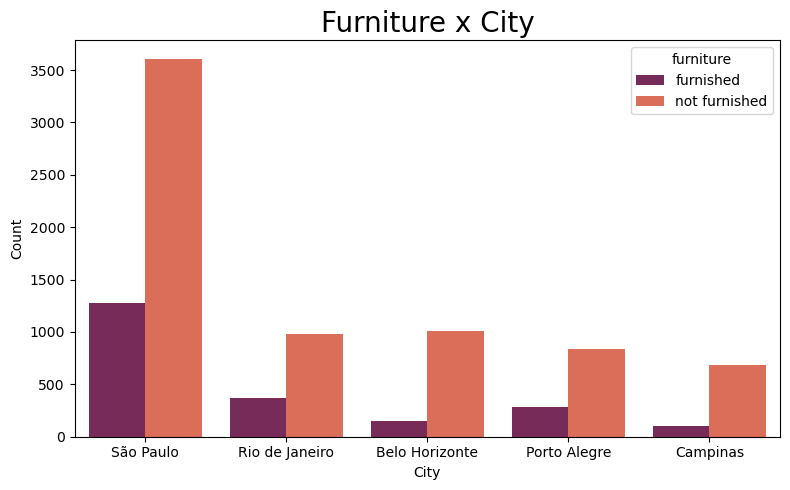

In [41]:
# casas mobiliadas por cidade

plt.figure(figsize=(8,5))
sns.countplot(data=df, x=df['city'], hue=df['furniture'], palette='rocket', order=df['city'].value_counts().index)
plt.ylabel('Count')
plt.xlabel('City')
plt.title('Furniture x City')

### Correlações 

#### dummies

In [42]:
df['animal'] = df['animal'].map({'acept':1, 'not acept':0})
df['furniture'] = df['furniture'].map({'furnished':1, 'not furished':0})

<AxesSubplot:>

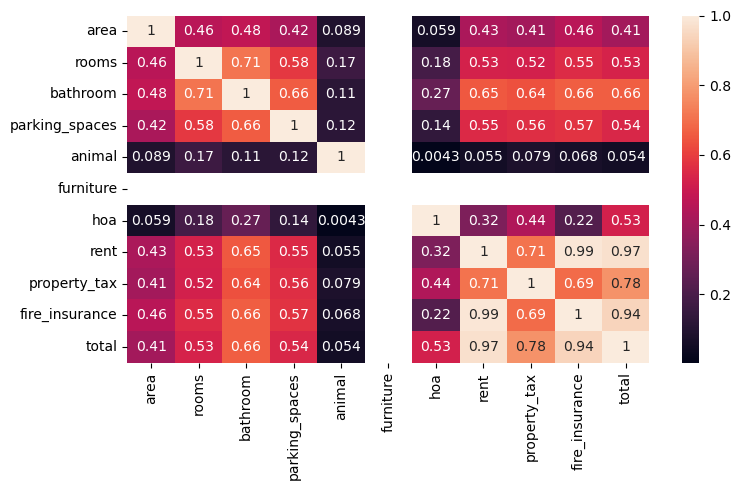

In [43]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(), annot=True)

No heatmap, podemos notar algumas fortes correlações que influenciam no valor total do aluguel, a variavel "fire_insurance", "rent", "property_tax","parking_spaces","bathroom", "rooms" e "hoa".

### Algumas conclusões:

- o dataset utilizado possui apenas registros de 5 cidades: São Paulo, Rio de Janeiro, Porto Alegre, Belo Horizonte, e Campinas;
- São Paulo possui mais casas disponiveis para alugar(52%). Deve-se levar em consideração que existem muito mais imóveis situados em São Paulo no DataFrame, constituindo mais de 50% dos dados;
- 77% dos imóveis aceitam animais;
- São Paulo é a cidade que mais aceita animais;
- a média de preço não varia de forma significativa por aceitar animais ou não;
- 76% dos imóveis não são mobiliados.

## Linear Regression

### preparando o modelo

In [44]:
# definindo X e y
# variaveis que possuem maior corr

X = df[['fire_insurance','property_tax','parking_spaces','bathroom','rooms','hoa']]
y = df['total']

In [45]:
# separando as bases de train e test 60%

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.60, random_state=42)

# verificando o tamanho de X_test e X_train
X_test.shape, X_train.shape

((5580, 6), (3720, 6))

In [46]:
# gerando o modelo LinearRegression

mdl = LinearRegression()

In [47]:
# treinando o algoritmo com a base de treino

mdl.fit(X_train, y_train)

LinearRegression()

In [48]:
# predição 

pred = mdl.predict(X_test)
pred.shape

(5580,)

In [49]:
# R-quadratico

r2_score(y_test, pred)

0.9898842979734174

In [50]:
# erro quadrado médio

mdl.score(X_test, y_test)

0.9898842979734174

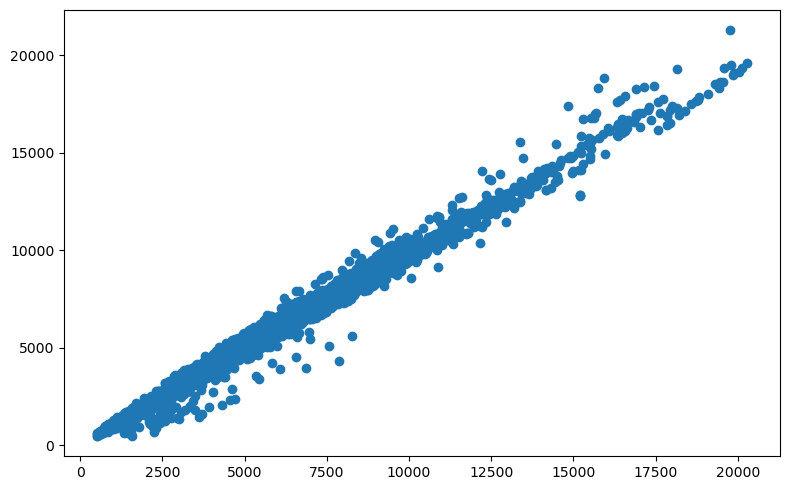

In [51]:
# resíduos

plt.figure(figsize=(8,5))
plt.scatter(y_test, pred)
plt.show()

In [53]:
# #testando o modelo

# dt_Test = pd.DataFrame({
#    "fire_insurance":42,
#    "property_tax":200,
#    "parking_spaces":[1],
#    "bathroom":1,
#    "rooms":2,
#    "hoa":2000
# })
# mdl.predict(dt_Test)

array([5930.85968142])